# Kansas CAI ~~Snark~~ Review

My friend from the internet asked me to look at a list of CAI's... I can't imagine what is about to go wrong.

Interactive: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/npappin-wsu/kansasCAI/HEAD?labpath=2-analysis.ipynb)


In [1]:
import pathlib, itables, pygris, numpy, folium, matplotlib, mapclassify, requests, json, zipfile, io, h3pandas
import pandas as pd
import geopandas as gpd
from pprint import pprint

itables.options.style = 'float:left;width:auto'

## Let's take a look

Time to crack open the list.

In [2]:
cai = pd.read_csv(pathlib.Path('data', 'cai.csv'))

In [3]:
itables.show(cai)

Lame! Let's just drop it in a map really quick: [here](https://felt.com/map/Kansas-CAI-Kpe4ZgiMSJm4IDOKFHlADD?loc=38.514,-98.322,7.93z&share=1) HT: Felt.com

Let's start to dig into the actual data. It's GEO TIME!!!

In [4]:
cai = gpd.GeoDataFrame(cai, geometry=gpd.points_from_xy(cai.Longitude, cai.Latitude), crs='EPSG:4326')

In [5]:
cai

,CAI Type,Entity name,Entity number,CMS number,FRN,Location ID,Street address,City,State or territory,Zip code,Longitude,Latitude,Explanation,Broadband Need,Broadband Availability,geometry
0,H,STEVENS COUNTY HOSPITAL,NaN,1.417079e+09,NaN,1.387117e+09,200 6TH STREET,HUGOTON,KS,67951,-101.345995,37.177650,NaN,1000.0,1000,POINT (-101.34600 37.17765)
1,S,TOPEKA WEST HIGH,77081.0,NaN,2.399033e+09,1.387107e+09,2001 SW Fairlawn Rd,Topeka,KS,66604,-95.747468,39.031338,NaN,1000.0,1000,POINT (-95.74747 39.03134)
2,S,WASHBURN INSTITUTE OF TECHNOLOGY,NaN,NaN,2.399033e+09,1.387107e+09,5724 SW Huntoon,Topeka,KS,66604,-95.749991,39.046591,NaN,1000.0,1000,POINT (-95.74999 39.04659)
3,G,KANSAS PUBLIC EMPLOYEES RETIREMENT SYSTEM,NaN,NaN,NaN,1.387107e+09,611 S Kansas Ave,Topeka,KS,66603,-95.674689,39.051257,NaN,1000.0,NaN,POINT (-95.67469 39.05126)
4,S,LANSING INTERMEDIATE SCHOOL,76562.0,NaN,2.399049e+09,1.387103e+09,200 E Mary St,Lansing,KS,66043,-94.896256,39.244347,NaN,1000.0,1000,POINT (-94.89626 39.24435)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,S,Kansas State University,NaN,NaN,NaN,NaN,501 S. Fairground Rd,Sublette,KS,67877,NaN,NaN,NaN,1000.0,NaN,POINT EMPTY
8830,S,Kansas State University,NaN,NaN,NaN,NaN,520 N Hamilton,Syracuse,KS,67878,NaN,NaN,NaN,1000.0,NaN,POINT EMPTY
8831,S,Kansas State University,NaN,NaN,NaN,NaN,1740 SW Western Ave,Topeka,KS,66604,NaN,NaN,NaN,1000.0,NaN,POINT EMPTY
8832,S,Kansas State University,NaN,NaN,NaN,NaN,105 S Liberty,Troy,KS,66087,NaN,NaN,NaN,1000.0,NaN,POINT EMPTY


There are a bunch of CAI's that don't have geodata/locationIds. So we are going to filter them now but they will be in the naughtyCai dataframe.

Well nevermind we have two different things, sometimes they have point data and no locationId and the opposite is also true... so actually we have four things...

In [6]:
naughtyCais = cai[(cai['Location ID'].isna()) & (cai.geometry.is_empty)]
cai = cai[((cai['Location ID'].isna()) & (cai.geometry.is_empty)) == False]
lostCais = cai[cai.geometry.is_empty]
cai = cai[cai.geometry.is_empty == False]
spookyCais = cai[cai['Location ID'].isna()]
cai = cai[cai['Location ID'].isna() == False]

Let's take a look at the naughty naughty CAIs. These don't have a location_id or a lat/long.

K-State, what are you doing over there? 😉

In [7]:
itables.show(naughtyCais)

Now lets take a look at spooky CAIs. These are places without location_ids so they are both here and not here. 👻

In [8]:
itables.show(spookyCais)

Write something funny here.

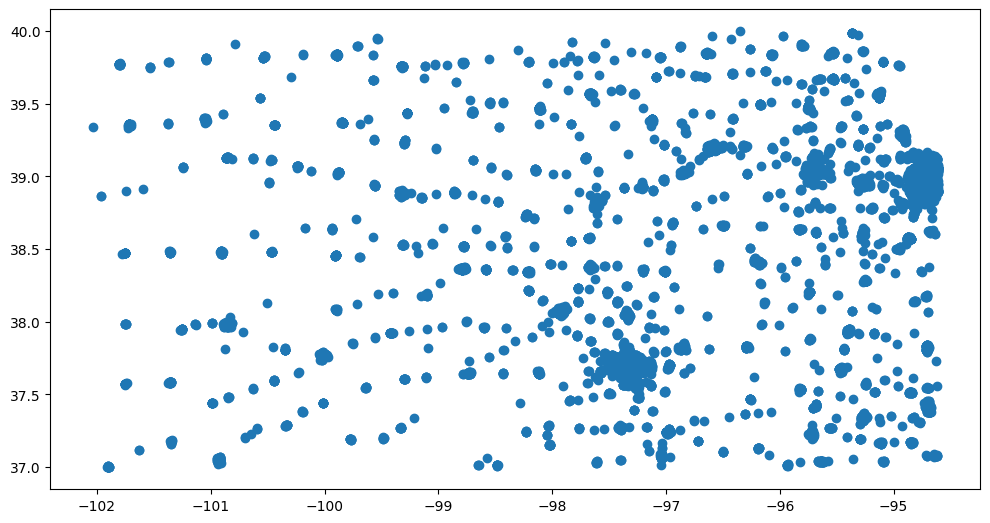

In [9]:
ax = cai.plot(figsize=(12, 12))

That's ugly... let's add color.

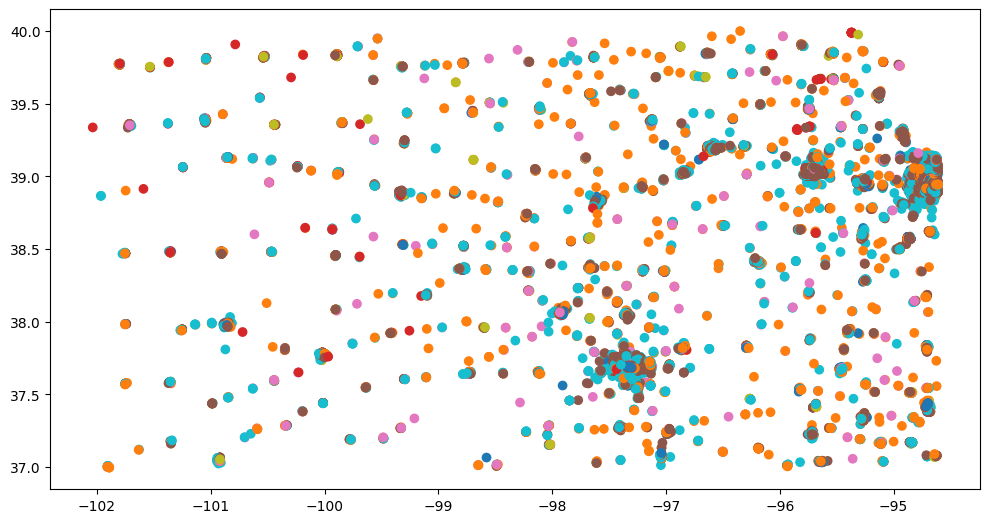

In [10]:
ax = cai.plot(column='CAI Type', figsize=(12,12))

But what if we looked at the city?

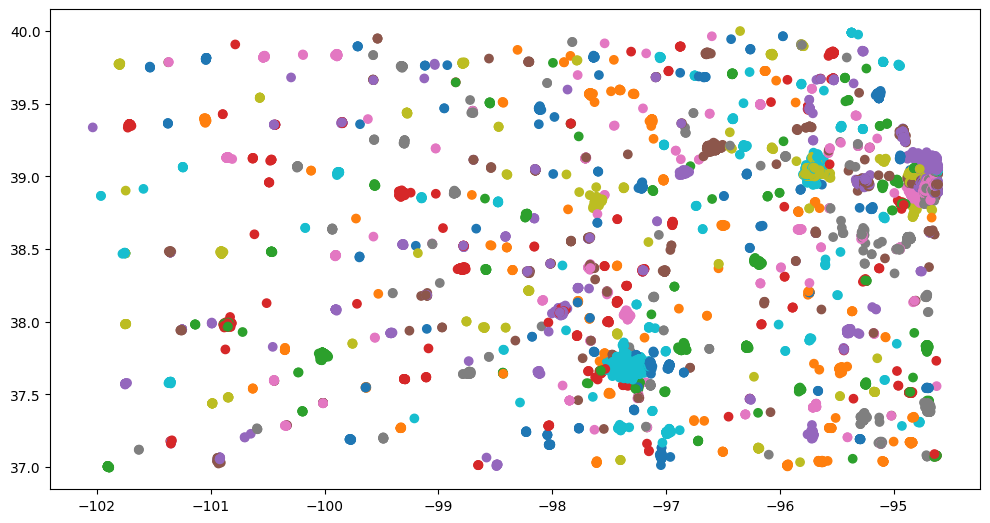

In [11]:
ax = cai.plot(column='City', figsize=(12,12))

Yeah that doesnt say much. Let's go grab some other data.

## The Data Part

Let's grab some availability data!

In [12]:
s = requests.Session()
s.headers.update({'User-Agent': 'j23servedAnalysis/0.0.1'})
url = 'https://broadbandmap.fcc.gov/nbm/map/api/published/filing'
response = s.get(url, timeout=5)
response
parsed = json.loads(response.text)
uuid = parsed['data'][2]['process_uuid']
pprint(parsed['data'][2])
pprint(uuid)
url = f"https://broadbandmap.fcc.gov/nbm/map/api/national_map_process/nbm_get_data_download/{uuid}/"
response = s.get(url, timeout=5)
parsed = json.loads(response.text)
filingData = pd.DataFrame(parsed['data'])
subsetAvalibility = filingData[(filingData.state_name == 'Kansas') & (filingData.file_type == 'csv')].reset_index()

{'enable_bfm_link': True,
 'enable_challenge_download': True,
 'filing_subtype': 'June 30, 2023',
 'filing_type': 'Biannual',
 'filing_type_id': 100007,
 'process_uuid': 'bd021722-8a6b-4709-8bcc-5a11859f69cf'}
'bd021722-8a6b-4709-8bcc-5a11859f69cf'


In [13]:
itables.show(subsetAvalibility)

Download Time!

In [14]:
baseUrl = ("https://broadbandmap.fcc.gov/nbm/map/api/getNBMDataDownloadFile/", "/1")

availabilityDf = pd.DataFrame()

columnHints={
    'block_geoid': str
}

for item in subsetAvalibility.to_dict('records'):
    # pprint(item)
    print(item['file_name'])
    # print(url)
    file = pathlib.Path('data', 'fcc-avail', f"{item['file_name']}.zip")
    if file.exists():
        with open(file, 'rb') as f:
            data = f.read()
    else:
        if pathlib.Path(file).parent.exists() == False:
            pathlib.Path(file.parent).mkdir()
        url = f"{baseUrl[0]}{item['id']}{baseUrl[1]}"
        r = s.get(url)
        with open(file, 'wb') as f:
            f.write(r.content)
        data = r.content
    zip = zipfile.ZipFile(io.BytesIO(data))
    df = pd.read_csv(zip.open(zip.filelist[0].filename), dtype=columnHints)
    availabilityDf = pd.concat([availabilityDf, df], ignore_index=True)

bdc_20_Other_fixed_broadband_J23_12dec2023
bdc_20_Copper_fixed_broadband_J23_12dec2023
bdc_20_Cable_fixed_broadband_J23_12dec2023
bdc_20_FibertothePremises_fixed_broadband_J23_12dec2023
bdc_20_GSOSatellite_fixed_broadband_J23_12dec2023
bdc_20_NGSOSatellite_fixed_broadband_J23_12dec2023
bdc_20_UnlicensedFixedWireless_fixed_broadband_J23_12dec2023
bdc_20_LicensedFixedWireless_fixed_broadband_J23_12dec2023
bdc_20_LBRFixedWireless_fixed_broadband_J23_12dec2023


In [15]:
availabilityDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10111627 entries, 0 to 10111626
Data columns (total 12 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   frn                            int64 
 1   provider_id                    int64 
 2   brand_name                     object
 3   location_id                    int64 
 4   technology                     int64 
 5   max_advertised_download_speed  int64 
 6   max_advertised_upload_speed    int64 
 7   low_latency                    int64 
 8   business_residential_code      object
 9   state_usps                     object
 10  block_geoid                    object
 11  h3_res8_id                     object
dtypes: int64(7), object(5)
memory usage: 925.7+ MB


In [16]:
itables.show(availabilityDf)

Let's build some locations!

In [17]:
locations = availabilityDf[[
    'location_id',
    'block_geoid',
    'h3_res8_id'
]].drop_duplicates().reset_index(drop=True)

In [18]:
itables.show(locations)

Useful things they pull out of the CAI list, number 1: Census Blocks, number 2: Hex IDs.

Let's add those back in!

In [19]:
cai = cai.merge(locations, left_on='Location ID', right_on='location_id', how='left')

Lets see how our merge did...

In [20]:
cai.location_id.isna().value_counts()

location_id
False    5728
True     1888
Name: count, dtype: int64

Well lets take a look at how it does across different availability releases...

dec2022:
False    3958
True     3658

jun2023:
False    5728
True     1888

Let's just go with June... I should do some more work and pull in data across all three availability releases.

Lets just take the hopeless CAIs out...

In [21]:
hopelessCais = cai[cai.location_id.isna()]
cai = cai[cai.location_id.isna() == False]

Now let's break apart the hex tiles from Census blocks and count the number of locations in the geographies.

In [22]:
h3Stats = locations.drop(columns=['location_id', 'block_geoid']).value_counts().reset_index()
blockStats = locations.drop(columns=['location_id', 'h3_res8_id']).value_counts().reset_index()

In [23]:
itables.show(h3Stats)

Make h3 geographies! I love hexagons. They are beautiful.

In [24]:
h3Stats = h3Stats.set_index('h3_res8_id').h3.h3_to_geo_boundary().reset_index()

Grab the Census data!

In [25]:
blockData = pygris.blocks(state='KS', cache=True)

Using the default year of 2021
Using FIPS code '20' for input 'KS'


In [26]:
itables.show(blockData)

In [27]:
itables.show(blockStats)

Join in the Census data to the Availability data!

In [28]:
blockstats = gpd.GeoDataFrame(blockStats.merge(blockData, left_on='block_geoid', right_on='GEOID20', how='left'))

<Axes: >

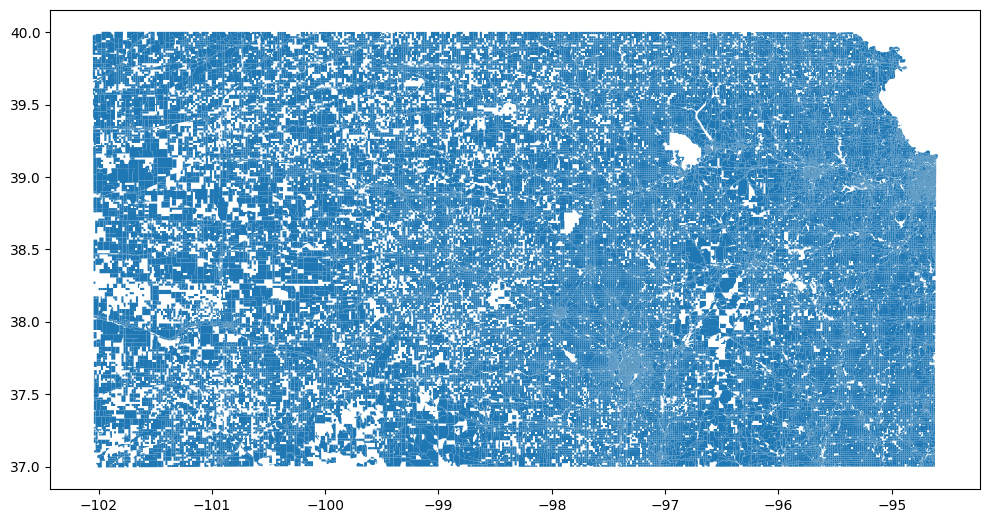

In [29]:
blockstats.plot(figsize=(12,12))

Whew, now that we have data what should we do?

Lets see if we can do an H3 Analysis!

## The H3 Part

In [30]:
itables.show(cai)

In [32]:
h3Stats['centroid'] = h3Stats.to_crs(3857).centroid.to_crs(4326)
h3Stats['boundary'] = h3Stats.geometry
h3Stats = h3Stats.drop(columns=['geometry'])

In [33]:
h3Stats[h3Stats.h3_res8_id == '8826e3d247fffff']

,h3_res8_id,count,centroid,boundary
3303,8826e3d247fffff,86,POINT (-97.50234 37.99106),"POLYGON ((-97.50200 37.98613, -97.49671 37.988..."


In [34]:
cai = cai.merge(h3Stats, left_on='h3_res8_id', right_on='h3_res8_id', how='left')
itables.show(cai)

In [67]:
cai['distToH3Center'] = cai.to_crs(3857).distance(cai.set_geometry('centroid').to_crs(3857))

<Axes: >

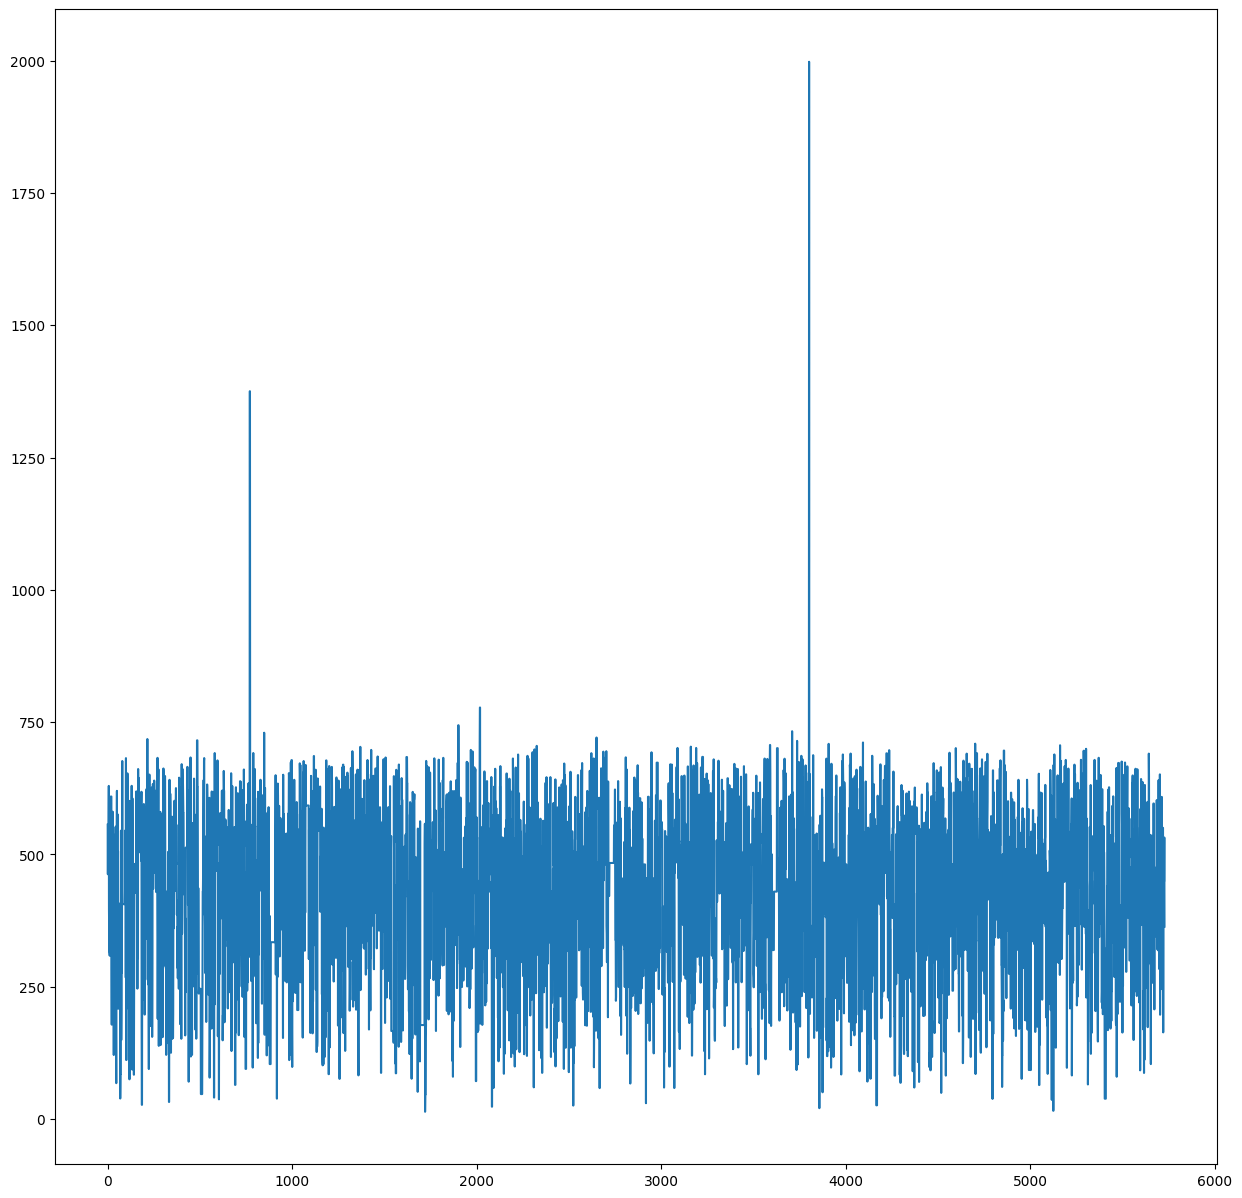

In [74]:
cai.distToH3Center.plot(figsize=(15,15))

In [75]:
cai.sort_values('distToH3Center').tail(5)

,CAI Type,Entity name,Entity number,CMS number,FRN,Location ID,Street address,City,State or territory,Zip code,...,Broadband Need,Broadband Availability,geometry,location_id,block_geoid,h3_res8_id,count,centroid,boundary,distToH3Center
2017,G,ATWOOD HOUSING AUTHORITY,NaN,NaN,NaN,1.136802e+09,801 S 3rd St,Atwood,KS,67730,...,1000.0,220,POINT (-101.04243 39.80025),1.136802e+09,201539506001132,8826f4c181fffff,70,POINT (-101.04870 39.79789),"POLYGON ((-101.04818 39.79303, -101.04281 39.7...",777.567821
2018,P,ATWOOD HOUSING AUTHORITY,NaN,NaN,NaN,1.136802e+09,801 S 3RD Street,Atwood,KS,67730,...,1000.0,220,POINT (-101.04243 39.80025),1.136802e+09,201539506001132,8826f4c181fffff,70,POINT (-101.04870 39.79789),"POLYGON ((-101.04818 39.79303, -101.04281 39.7...",777.567821
771,F,NORTH HANGER,NaN,NaN,NaN,1.340253e+09,3800 S. Oliver Ave,Wichita,KS,67210,...,1000.0,200,POINT (-97.27924 37.62542),1.340253e+09,201730066002043,8826e3130bfffff,1,POINT (-97.27512 37.61619),"POLYGON ((-97.27479 37.61126, -97.26951 37.613...",1375.298123
770,F,NE MFG FACILITY,NaN,NaN,NaN,1.340253e+09,3800 S. Oliver,Wichita,KS,67210,...,1000.0,200,POINT (-97.27924 37.62542),1.340253e+09,201730066002043,8826e3130bfffff,1,POINT (-97.27512 37.61619),"POLYGON ((-97.27479 37.61126, -97.26951 37.613...",1375.298123
3801,L,KANSAS CITY PUBLIC LIBRARY,137612.0,NaN,NaN,1.108426e+09,4051 W. Drive,Kansas City,KS,66109,...,1000.0,100,POINT (-94.78289 39.15956),1.108426e+09,202090446013003,8826564645fffff,5,POINT (-94.78724 39.17306),"POLYGON ((-94.78703 39.16822, -94.78169 39.170...",1998.014161


Honestly, I am going to stop this analysis now. It really is looking pretty good and generally uninteresting. 

Sad, I was really hoping for another Illinois!

If you have any questions you want me to answer please let me know and I will add them to this analsys. Feel free to open an issue!